# Applying a "Transform, Encode, KNN search" framework to match items with Amazon SageMaker and Amazon OpenSearch Service

## Set up notebook environment

In [2]:
%pip install --upgrade sagemaker==2.135.0 -q


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [47]:
import ast

import pandas as pd
import numpy as np
import json
import sagemaker
import time
import boto3
%matplotlib inline

sagemaker.__version__

'2.135.0'

In [42]:
!python build_config.py

Config setup completed! The config file can be found in tox.ini and ./pipelines/sim_items/config.py


In [48]:
from configparser import ConfigParser
import boto3


config_ = ConfigParser()
config_.read("tox.ini")

model_package_group_name = config_["sim-items:notebook"]["model_package_group_name"]
pipeline_name = config_["sim-items:notebook"]["pipeline_name"]
opensearch_url = config_["sim-items:notebook"]["opensearch_url"]
opensearch_index_name = config_["sim-items:notebook"]["opensearch_index_name"]
endpoint_name = config_["sim-items:notebook"]["endpoint_name"]
region = config_["sim-items:notebook"]["region"]
role = config_["sim-items:notebook"]["role"]
bucket = config_["sim-items:notebook"]["default_bucket"]
raw_data_url = config_["sim-items:notebook"]["raw_data_url"]

security_group = config_["sim-items:notebook"]["security_group"]
subnets = ast.literal_eval(config_["sim-items:notebook"]["subnets"])

In [6]:
# Get SageMaker session & default S3 bucket
sagemaker_session = sagemaker.Session()
s3 = sagemaker_session.boto_session.resource('s3')

## Data prepare

In [7]:
!mkdir -p data
# Delete file if already exists
! rm -f data/meta_Office_Products.json.gz
# Downloading the book metadata
! wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/meta_Office_Products.json.gz -O data/meta_Office_Products.json.gz

--2023-02-28 10:28:48--  http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/meta_Office_Products.json.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47605216 (45M) [application/x-gzip]
Saving to: ‘data/meta_Office_Products.json.gz’

data/meta_Office_Pr 100%[===================>]  45.40M  9.49MB/s    in 11s     

2023-02-28 10:29:00 (4.08 MB/s) - ‘data/meta_Office_Products.json.gz’ saved [47605216/47605216]



In [8]:
import pandas as pd
import gzip
import ast

def parse(path, limit):
    g = gzip.open(path, 'rb')
    for idx, line in enumerate(g):
        if idx < limit:
            yield ast.literal_eval(line.decode())
        else:
            break

def get_df(path, limit=10):
    data = {
      idx: dict_
      for idx, dict_ in enumerate(parse(path, limit))

    }
    return pd.DataFrame.from_dict(data, orient='index')

df = get_df('data/meta_Office_Products.json.gz', limit=10000)

In [9]:
df.head()

,asin,description,price,imUrl,related,salesRank,categories,title,brand
0,0078800242,All in one TeacherWorks Plus CD-ROM,93.06,http://ecx.images-amazon.com/images/I/41K1aBkl...,{'buy_after_viewing': ['007861970X']},{'Software': 18529},"[[Office Products, Office & School Supplies, C...",NaN,NaN
1,0113000316,High quality inkjet cartridges use high-densit...,NaN,http://ecx.images-amazon.com/images/I/51AMwP3D...,NaN,NaN,"[[Office Products, Office & School Supplies, P...",123GetInk -14-pack 5-black 3-cyan 3-magenta 3-...,NaN
2,043928631X,"Harry Potter living bookmark showing Harry, He...",NaN,http://ecx.images-amazon.com/images/I/41SulB7T...,NaN,NaN,"[[Office Products, Office & School Supplies, L...",Harry Potter Lenticular Hologram Bookmark - Ha...,NaN
3,0439340039,Windows based computer game.,NaN,http://ecx.images-amazon.com/images/I/51zQE0w%...,NaN,{'Software': 32784},"[[Office Products, Office & School Supplies, E...",NaN,NaN
4,0439394058,"126 pieces: 23"" tall schoolhouse calendar, 12 ...",11.64,http://ecx.images-amazon.com/images/I/51DFp0Lg...,"{'also_bought': ['B000QE1HHU', 'B00207MG4Y', '...",NaN,"[[Office Products, Office & School Supplies, E...",Scholastic SC939405 All-In-One Schoolhouse Cal...,Scholastic


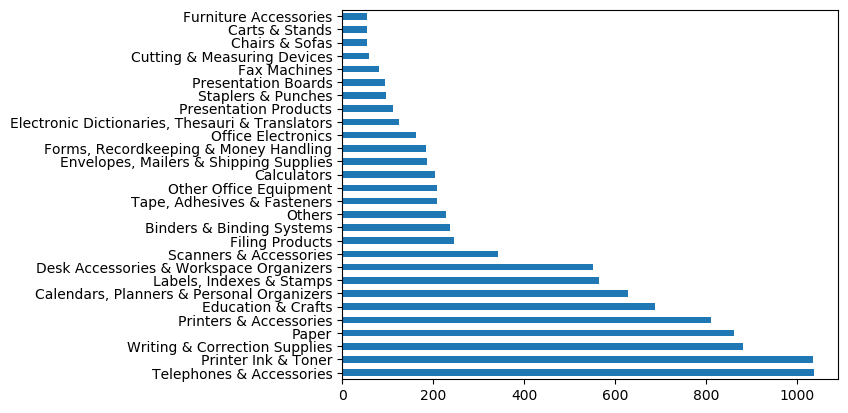

In [10]:
def pick_level_3_cate(cates_series):
    if len(cates_series) > 1:
        for item in cates_series:
            if item[0] == 'Office Products':
                cates = item
                break
    else:
        cates = cates_series[0]
    # ['Office Products', 'Office & School Supplies', 'Education & Crafts', 'Teaching Materials']
    return cates[2] if len(cates) >= 3 else cates[1]
level_3_cate = df.categories.apply(pick_level_3_cate)

cate_ratio = level_3_cate.value_counts() / len(level_3_cate)
rare_classes = set(cate_ratio[cate_ratio < 0.005].index.tolist())
level_3_cate[level_3_cate.isin(rare_classes)] = "Others"

df = df.assign(label=level_3_cate)
df.label.value_counts().plot(kind='barh')

In [11]:
df.to_csv(raw_data_url,index=False)

## Execute a Pipeline

### Orchestrating Jobs, Model Registration, and Continuous Deployment with Amazon SageMaker

Amazon SageMaker offers Machine Learning application developers and Machine Learning operations engineers the ability to orchestrate SageMaker jobs and author reproducible Machine Learning pipelines, deploy custom-build models for inference in real-time with low latency or offline inferences with Batch Transform, and track lineage of artifacts. You can institute sound operational practices in deploying and monitoring production workflows, deployment of model artifacts, and track artifact lineage through a simple interface, adhering to safety and best-practice paradigmsfor Machine Learning application development.

The SageMaker Pipelines service supports a SageMaker Machine Learning Pipeline Domain Specific Language (DSL), which is a declarative Json specification. This DSL defines a Directed Acyclic Graph (DAG) of pipeline parameters and SageMaker job steps. The SageMaker Python Software Developer Kit (SDK) streamlines the generation of the pipeline DSL using constructs that are already familiar to engineers and scientists alike.

The SageMaker Model Registry is where trained models are stored, versioned, and managed. Data Scientists and Machine Learning Engineers can compare model versions, approve models for deployment, and deploy models from different AWS accounts, all from a single Model Registry. SageMaker enables customers to follow the best practices with ML Ops and getting started right. Customers are able to standup a full ML Ops end-to-end system with a single API call.

### Layout of the SageMaker ModelBuild Project

The template provides a starting point for bringing your SageMaker Pipeline development to production.

```
|-- codebuild-buildspec.yml
|-- CONTRIBUTING.md
|-- pipelines
|   |-- sim_items
|   |   |-- __init__.py
|   |   `-- pipeline.py
|   |-- get_pipeline_definition.py
|   |-- __init__.py
|   |-- run_pipeline.py
|   |-- _utils.py
|   `-- __version__.py
|-- sim_items_src
|   |-- config.py
|   |-- __init__.py
|   |-- inference.py
|   |-- knn_index.py
|   |-- requirements.txt
|   `-- utils.py
|-- README.md
|-- sagemaker-similar-items.ipynb
|-- setup.cfg
|-- setup.py
|-- tests
|   |-- conftest.py
|   |-- integration
|   |   |-- test_components.py
|   |   |-- test_endpoint.py
|   |   `-- test_pipelines.py
|   `-- unit
|      `-- test_inference.py
`-- tox.ini
```

A description of some of the artifacts is provided below:
<br/><br/>
Your codebuild execution instructions:
```
|-- codebuild-buildspec.yml
```
<br/><br/>
Your pipeline artifacts, which includes a pipeline module defining the required `get_pipeline` method that returns an instance of a SageMaker pipeline, a preprocessing script that is used in feature engineering, and an OpenSearch indexing script to ingest data to an OpenSearch service cluster is included in the pipeline:

```
|-- pipelines
|   |-- sim_items
|   |   |-- __init__.py
|   |   `-- pipeline.py

```
<br/><br/>
Utility modules for getting pipeline definition jsons and running pipelines:

```
|-- pipelines
|   |-- get_pipeline_definition.py
|   |-- __init__.py
|   |-- run_pipeline.py
|   |-- _utils.py
|   `-- __version__.py
```

<br/><br/>
SageMaker Processing jobs and SageMaker Model are going to use the following Python Module to preprecess data, ingest OpenSearch Index, and query the OpenSearch service index:
```
|-- sim_items_src
|   |-- config.py
|   |-- __init__.py
|   |-- inference.py
|   |-- knn_index.py
|   |-- requirements.txt
|   `-- utils.py
```

<br/><br/>
Python package artifacts:
```
|-- setup.cfg
|-- setup.py
```
<br/><br/>
A stubbed testing module for testing your pipeline as you develop:
```
|-- tests
|   |-- conftest.py
|   |-- integration
|   |   |-- test_components.py
|   |   |-- test_endpoint.py
|   |   `-- test_pipelines.py
|   `-- unit
|      `-- test_inference.py
```
<br/><br/>
The `tox` testing framework configuration:
```
`-- tox.ini
```

### A SageMaker Pipeline

The pipeline that we include pre-processing, training, model registration, generate embeddings of items, and ingesting embeddings to a OpenSearch service domain.

![A typical ML Application pipeline](img/sim-items-pipeline.png)

### Get the pipeline instance

Here we get the pipeline instance from your pipeline module so that we can work with it.



In [12]:
from pipelines.sim_items.pipeline import get_pipeline


pipeline = get_pipeline(
    region=region,
    role=role,
    default_bucket=bucket,
    model_package_group_name=model_package_group_name,
    pipeline_name=pipeline_name,
)

/opt/conda/lib/python3.7/site-packages/sagemaker/workflow/pipeline_context.py:261: UserWarning: Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.
  UserWarning,


### Submit the pipeline to SageMaker and start execution

Let's submit our pipeline definition to the workflow service. The role passed in will be used by the workflow service to create all the jobs defined in the steps.

In [13]:
pipeline.upsert(role_arn=role)

INFO:sagemaker.processing:Uploaded /root/similar-items/sim_items_src to s3://sagemaker-ap-southeast-2-071965382733/SimItemsPipeline-Example/code/fcb520d07554c95c5315b1d03636bfca/sourcedir.tar.gz
INFO:sagemaker.processing:runproc.sh uploaded to s3://sagemaker-ap-southeast-2-071965382733/SimItemsPipeline-Example/code/9214eac7904ff13a35ad783d9b45d74b/runproc.sh
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.processing:Uploaded /root/similar-items/sim_items_src to s3://sagemaker-ap-southeast-2-071965382733/SimItemsPipeline-Example/code/3ee7568ac4a85d5726b38f798ba61d25/sourcedir.tar.gz
INFO:sagemaker.processing:runproc.sh uploaded to s3://sagemaker-ap-southeast-2-071965382733/SimItemsPipeline-Example/code/7a0e3299148e25143012036aa1fbdbd5/runproc.sh
/opt/conda/lib/python3.7/site-packages/sagemaker/w

{'PipelineArn': 'arn:aws:sagemaker:ap-southeast-2:071965382733:pipeline/simitemspipeline-example',
 'ResponseMetadata': {'RequestId': 'c570eb7f-030f-4a20-a3d2-02ef7c816dda',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'c570eb7f-030f-4a20-a3d2-02ef7c816dda',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '97',
   'date': 'Tue, 28 Feb 2023 10:29:52 GMT'},
  'RetryAttempts': 0}}

### Subsequent runs

Once the baselines have been created for the first time, the default parameters of the pipeline can be used on subsequent runs so that new baselines are compared against old ones if model version approved.

The default parameters are overriden as the first time the pipeline is executed

In [14]:

execution = pipeline.start(
    parameters=dict(
        InputData=raw_data_url,
        OpenSearchUrl=opensearch_url,
        OpenSearchIndexName=opensearch_index_name,
    )
)

### Pipeline Operations: examining and waiting for pipeline execution

Now we describe execution instance and list the steps in the execution to find out more about the execution.

In [15]:
execution.describe()

{'PipelineArn': 'arn:aws:sagemaker:ap-southeast-2:071965382733:pipeline/simitemspipeline-example',
 'PipelineExecutionArn': 'arn:aws:sagemaker:ap-southeast-2:071965382733:pipeline/simitemspipeline-example/execution/eapqdnngd50h',
 'PipelineExecutionDisplayName': 'execution-1677580193985',
 'PipelineExecutionStatus': 'Executing',
 'CreationTime': datetime.datetime(2023, 2, 28, 10, 29, 53, 904000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2023, 2, 28, 10, 29, 53, 904000, tzinfo=tzlocal()),
 'CreatedBy': {'UserProfileArn': 'arn:aws:sagemaker:ap-southeast-2:071965382733:user-profile/d-zkamdzjwfszl/clip-user',
  'UserProfileName': 'clip-user',
  'DomainId': 'd-zkamdzjwfszl'},
 'LastModifiedBy': {'UserProfileArn': 'arn:aws:sagemaker:ap-southeast-2:071965382733:user-profile/d-zkamdzjwfszl/clip-user',
  'UserProfileName': 'clip-user',
  'DomainId': 'd-zkamdzjwfszl'},
 'ResponseMetadata': {'RequestId': 'd4097923-7068-49cc-9c56-a9749be7b1c3',
  'HTTPStatusCode': 200,
  'HTTPHeade

We can wait for the execution by invoking `wait()` on the execution:

In [16]:
execution.wait(delay=30, max_attempts=120)

## Verify the generate ML model and embeddings

### Deploy latest approved model to a real-time endpoint

In [28]:
from botocore.exceptions import ClientError
import os
import boto3
import sagemaker
import logging
from sagemaker import ModelPackage


logger = logging.getLogger(__name__)
sm_client = boto3.client("sagemaker")


def get_approved_package(model_package_group_name):
    """Gets the latest approved model package for a model package group.

    Args:
        model_package_group_name: The model package group name.

    Returns:
        The SageMaker Model Package ARN.
    """
    try:
        # Get the latest approved model package
        response = sm_client.list_model_packages(
            ModelPackageGroupName=model_package_group_name,
            ModelApprovalStatus="Approved",
            SortBy="CreationTime",
            MaxResults=100,
        )
        approved_packages = response["ModelPackageSummaryList"]

        # Fetch more packages if none returned with continuation token
        while len(approved_packages) == 0 and "NextToken" in response:
            logger.debug(
                "Getting more packages for token: {}".format(response["NextToken"])
            )
            response = sm_client.list_model_packages(
                ModelPackageGroupName=model_package_group_name,
                ModelApprovalStatus="Approved",
                SortBy="CreationTime",
                MaxResults=100,
                NextToken=response["NextToken"],
            )
            approved_packages.extend(response["ModelPackageSummaryList"])

        # Return error if no packages found
        if len(approved_packages) == 0:
            error_message = f"No approved ModelPackage found for ModelPackageGroup: {model_package_group_name}"
            logger.error(error_message)
            raise Exception(error_message)

        # Return the pmodel package arn
        model_package_arn = approved_packages[0]["ModelPackageArn"]
        logger.info(
            f"Identified the latest approved model package: {model_package_arn}"
        )
        return approved_packages[0]
        # return model_package_arn
    except ClientError as e:
        error_message = e.response["Error"]["Message"]
        logger.error(error_message)
        raise Exception(error_message)

In [50]:


sm_client = boto3.client("sagemaker")

pck = get_approved_package(
    model_package_group_name
)
model_description = sm_client.describe_model_package(
    ModelPackageName=pck["ModelPackageArn"]
)

sess = boto3.Session()

sagemaker_session = sagemaker.Session(boto_session=sess)

model_package_arn = model_description["ModelPackageArn"]
model = ModelPackage(
    role=role,
    model_package_arn=model_package_arn,
    sagemaker_session=sagemaker_session,
    vpc_config=dict(
        SecurityGroupIds=[security_group],
        Subnets=subnets
    )
)
model.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.xlarge",
    endpoint_name=endpoint_name,
)


INFO:__main__:Identified the latest approved model package: arn:aws:sagemaker:ap-southeast-2:071965382733:model-package/simitemsmodelpackagegroup-example/2
INFO:sagemaker:Creating model with name: 2-2023-02-28-23-20-27-134
INFO:sagemaker:Creating endpoint-config with name SIM-ITEMS-test-endpoint
INFO:sagemaker:Creating endpoint with name SIM-ITEMS-test-endpoint


----------------!

### Verify the model accuracy using the raw test data

In [52]:
response = sm_client.list_pipeline_executions(
    PipelineName=pipeline_name,
    SortBy='CreationTime',
    SortOrder='Descending',
)

for execution in response["PipelineExecutionSummaries"]:
    if execution['PipelineExecutionStatus'] == 'Stopped':
        break

response = sm_client.describe_pipeline_definition_for_execution(
    PipelineExecutionArn=execution['PipelineExecutionArn']
)



steps = json.loads(response['PipelineDefinition'])['Steps']
outputs = next((
    step
    for step in steps
    if step['Name'] == 'SimItemsProcess'
))['Arguments']['ProcessingOutputConfig']['Outputs']

test_path = next(( output_ for output_ in outputs if output_['OutputName'] == "raw_test"))['S3Output']['S3Uri']
test_path

's3://sagemaker-ap-southeast-2-071965382733/SimItemsSplit-2023-02-27-08-44-11-908/output/raw_test'

In [53]:
raw_feature_columns_names = [
    "asin",
    "description",
    "price",
    "imUrl",
    "related",
    "salesRank",
    "categories",
    "title",
    "brand",
]
label_column = "label"

output_raw_columns = [label_column] + raw_feature_columns_names

test_data = pd.read_csv(f"{test_path}/test.csv", header=None, names=output_raw_columns)

In [54]:
test_data = test_data[~test_data.description.isna()]
test_data = test_data[~test_data.title.isna()]

In [55]:
ground_true = test_data.pop(label_column)
instances = test_data.copy()

In [56]:
from sagemaker.predictor import Predictor
from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import CSVSerializer

predictor = Predictor(
    endpoint_name=endpoint_name,
    serializer=CSVSerializer(),
    deserializer=JSONDeserializer(),
    content_type="text/csv",
    accept="application/json",
)


See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [57]:
res = predictor.predict(instances.head().to_csv(index=False, header=False))

In [62]:
instances.loc[instances.title.str.len()>500, "title"] = instances[instances.title.str.len()>500].title.str[0:500]
instances.loc[instances.description.str.len()>500, "description"] = instances[instances.description.str.len()>500].description.str[0:500]

In [64]:
bz_ = 8
predictions = []
from tqdm import tqdm

for batch_ in tqdm(range(len(instances) // bz_ + 1)):
    batch_instances = instances[batch_*bz_: (batch_+1)*bz_]
    batch_predictions = predictor.predict(batch_instances.to_csv(index=False, header=False))
    predictions.extend(batch_predictions)



  0%|          | 0/114 [00:00<?, ?it/s]

  1%|          | 1/114 [00:01<02:50,  1.51s/it]

  2%|▏         | 2/114 [00:03<02:58,  1.60s/it]

  3%|▎         | 3/114 [00:04<02:37,  1.42s/it]

  4%|▎         | 4/114 [00:05<02:29,  1.36s/it]

  4%|▍         | 5/114 [00:06<02:17,  1.26s/it]

  5%|▌         | 6/114 [00:07<02:15,  1.26s/it]

  6%|▌         | 7/114 [00:09<02:12,  1.24s/it]

  7%|▋         | 8/114 [00:10<02:08,  1.22s/it]

  8%|▊         | 9/114 [00:11<02:08,  1.22s/it]

  9%|▉         | 10/114 [00:12<02:02,  1.17s/it]

 10%|▉         | 11/114 [00:13<02:00,  1.17s/it]

 11%|█         | 12/114 [00:14<01:54,  1.13s/it]

 11%|█▏        | 13/114 [00:15<01:56,  1.15s/it]

 12%|█▏        | 14/114 [00:16<01:54,  1.14s/it]

 13%|█▎        | 15/114 [00:18<01:49,  1.11s/it]

 14%|█▍        | 16/114 [00:19<01:50,  1.13s/it]

 15%|█▍        | 17/114 [00:20<01:50,  1.14s/it]

 16%|█▌        | 18/114 [00:21<01:47,  1.12s/it]

 17%|█▋        | 19/114 [00:22<01:44,  1.10s/it]

 18%|█▊        |

In [65]:
predicted_label = [item['label'] for item in predictions]

In [66]:
from sklearn import metrics
print(metrics.classification_report(ground_true, predicted_label))

                                                 precision    recall  f1-score   support

                      Binders & Binding Systems       0.71      0.83      0.77        18
                                    Calculators       1.00      1.00      1.00        12
      Calendars, Planners & Personal Organizers       0.98      0.98      0.98        47
                                 Carts & Stands       0.00      0.00      0.00         4
                                 Chairs & Sofas       0.80      0.80      0.80         5
                    Cutting & Measuring Devices       1.00      1.00      1.00         3
        Desk Accessories & Workspace Organizers       0.54      0.86      0.67        44
                             Education & Crafts       0.90      0.94      0.92        70
Electronic Dictionaries, Thesauri & Translators       0.86      0.75      0.80         8
         Envelopes, Mailers & Shipping Supplies       0.91      0.83      0.87        12
                    

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Visualize the embedding

In [67]:
embeddings = np.array([item['embedding'] for item in predictions])

In [68]:
evaluation_data = ground_true.to_frame()

In [69]:
from sklearn.manifold import TSNE

# The default of 1,000 iterations gives fine results, but I'm training for longer just to eke
# out some marginal improvements. NB: This takes almost an hour!
tsne = TSNE(random_state=1, n_iter=2000, metric="cosine")

embs = tsne.fit_transform(embeddings)
# Add to dataframe for convenience
evaluation_data = evaluation_data.assign(x = embs[:, 0])
evaluation_data = evaluation_data.assign(y = embs[:, 1])

# evaluation_data['x'] = embs[:, 0]
# evaluation_data['y'] = embs[:, 1]

from matplotlib import pyplot as plt
%matplotlib inline

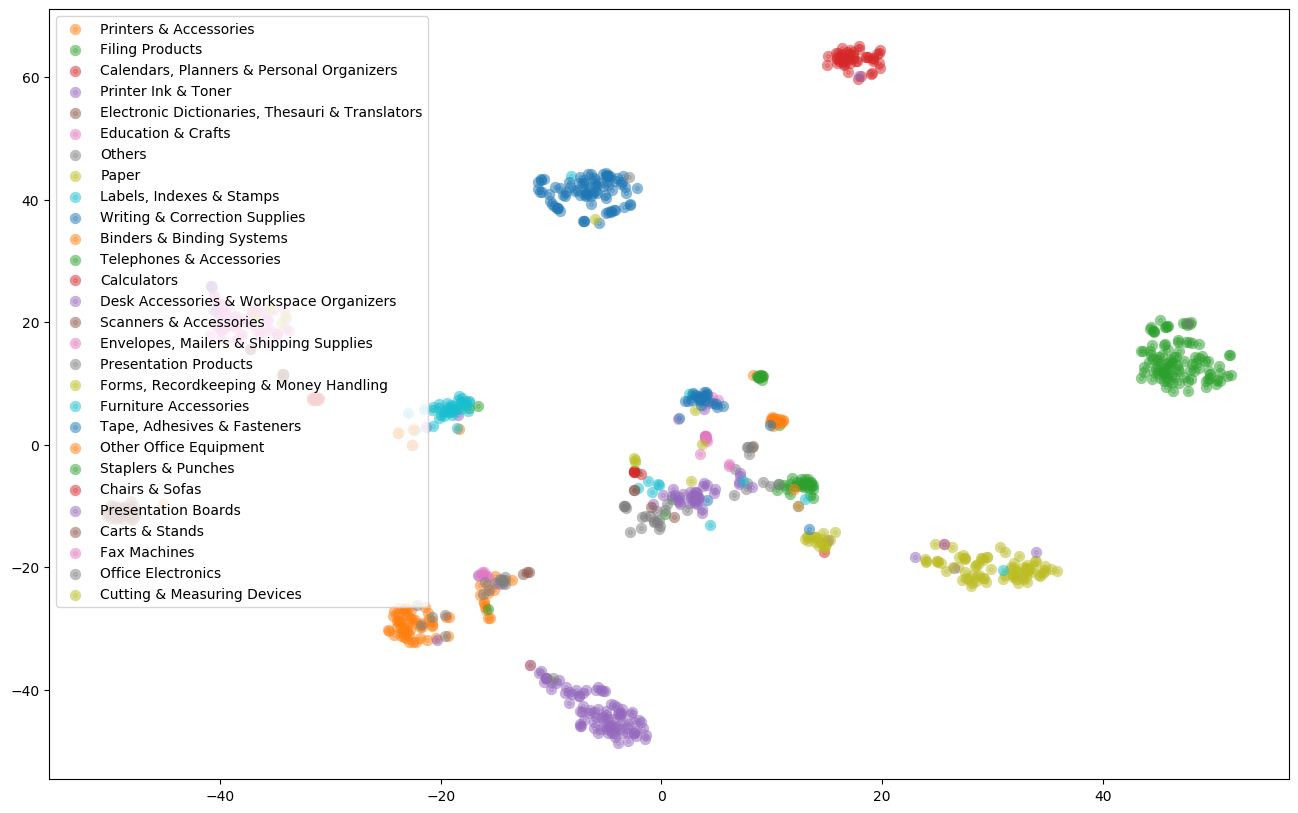

In [70]:
import itertools
sample_rate = 1
components = evaluation_data.label.unique().tolist()


def plot_bg(bg_alpha=.01, figsize=(13, 9), emb_2d=None):
    """Create and return a plot of all our movie embeddings with very low opacity.
    (Intended to be used as a basis for further - more prominent - plotting of a 
    subset of movies. Having the overall shape of the map space in the background is
    useful for context.)
    """
    if emb_2d is None:
        emb_2d = embs
    fig, ax = plt.subplots(figsize=figsize)
    X = emb_2d[:, 0]
    Y = emb_2d[:, 1]
    ax.scatter(X, Y, alpha=bg_alpha)
    return ax

def add_annotations(ax, label_indices, emb_2d=None, **kwargs):
    if emb_2d is None:
        emb_2d = embs
    X = m.x
    Y = m.y
    ax.scatter(X, Y, **kwargs)


ax = plot_bg(figsize=(16, 10))

for i, label_ in enumerate(components):
    m = evaluation_data[evaluation_data.label == label_]
    marker = str(i+1)
    add_annotations(ax, m.index, label=label_, emb_2d=m, alpha=.5, s=10, linewidths=5) #  
plt.legend(); 

### Check the similar items

In [71]:
item_predictions = predictions[0]
item_predictions.pop('embedding');

In [72]:
predictions[2]['label']

'Calendars, Planners & Personal Organizers'

In [73]:
item_idx = 3

print(f"Predicted label: {predictions[item_idx]['label']}")

print("Similar items are")
[
    dict(
        label=item['_source']['label'],
        title=item['_source']['title'],
    )
    for item in predictions[item_idx]['similar_items']
]

Predicted label: Printer Ink & Toner
Similar items are


[{'label': 'Filing Products',
  'title': 'Smead Hanging Folder, Letter, 1/5 Cut Tab, Purple, 25 per Box (64072)'},
 {'label': 'Writing & Correction Supplies',
  'title': 'Waterman Ball Point Refill Maxima Fine Blue'},
 {'label': 'Filing Products',
  'title': 'Pendaflex J044 Pendaflex Expandable Retention Jackets, Lgl/Ltr, Kraft Brown, 100/Bx'},
 {'label': 'Telephones & Accessories',
  'title': 'Olympia OL 2461 2.4 GHz DSS Cordless Phone with Dual Handsets and Caller ID (Silver)'},
 {'label': 'Writing & Correction Supplies',
  'title': 'Waterman Charleston Black CT Rollerball Pen - 30224'}]

## Cleaning up

When you finish this exercise, remove your resources with the following steps:

In [74]:
sm_client.delete_endpoint(EndpointName=endpoint_name)
sm_client.delete_endpoint_config(EndpointConfigName=endpoint_name)

{'ResponseMetadata': {'RequestId': 'ea8b40fd-c8ba-428c-84ba-7b3b96e1c1cf',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'ea8b40fd-c8ba-428c-84ba-7b3b96e1c1cf',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Tue, 28 Feb 2023 23:35:42 GMT'},
  'RetryAttempts': 0}}